In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

%matplotlib inline

In [83]:
bounds = np.array([[-3.0, 5.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-2.1], [3.1]])
Y_init = f(X_init)

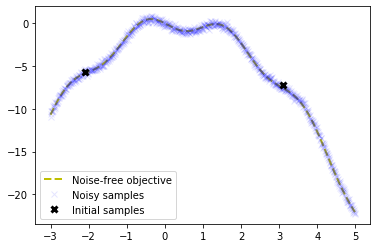

In [85]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [37]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [67]:
def random_location(bounds):
    tmp = np.ndarray((1, 1))
    tmp[0][0] = np.random.random() * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
    return tmp

def grid_search():
    pass

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

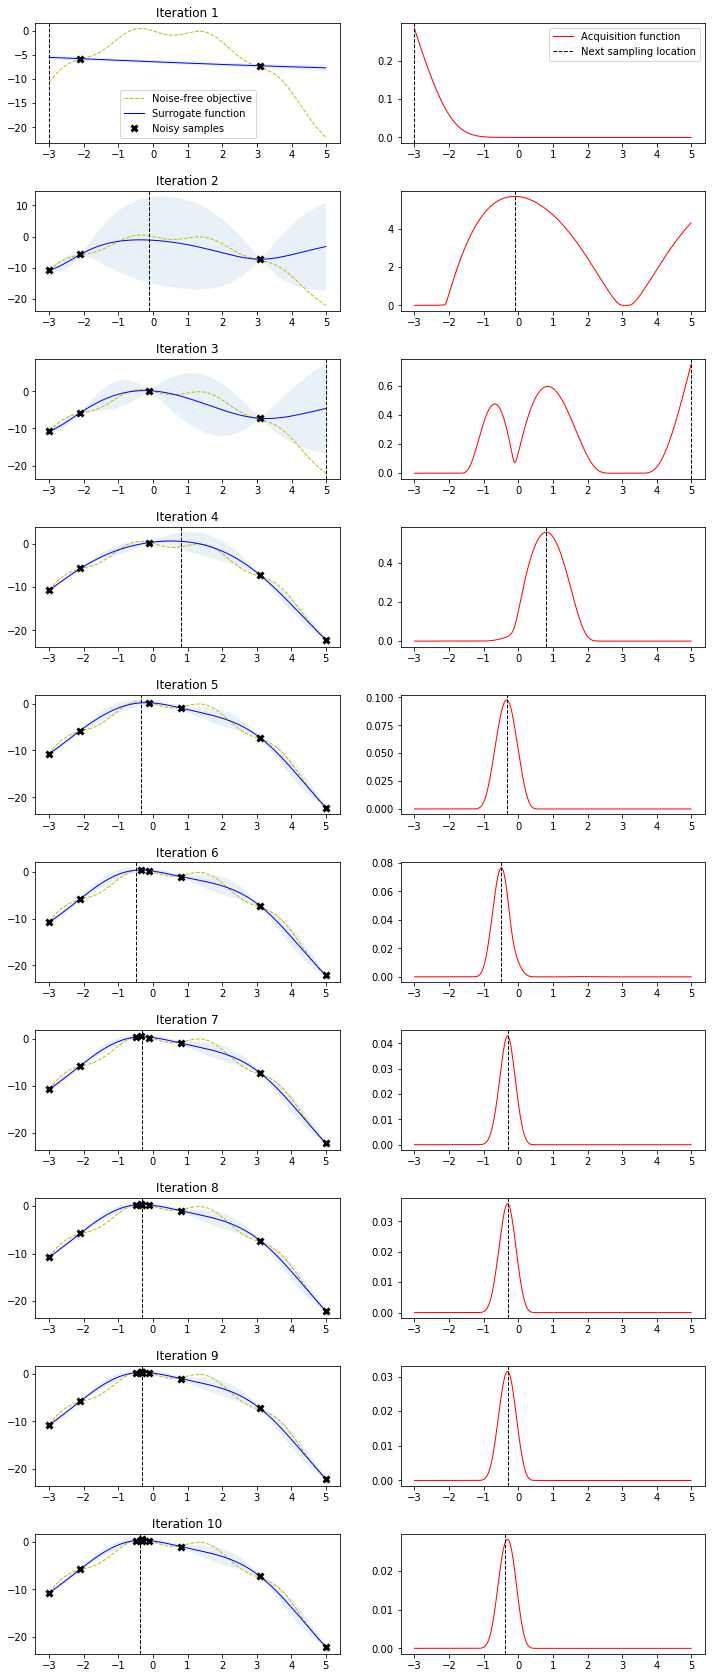

In [113]:
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    # X_next = random_location(bounds)
    #print(type(X_next))
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

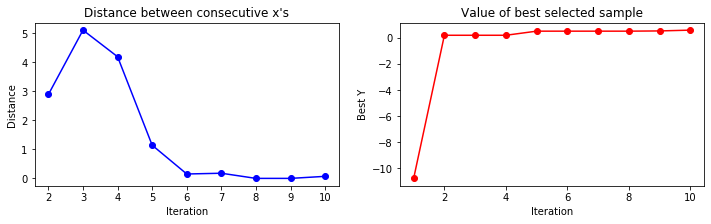

In [114]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

20
20
20
20
20
20
20
20
20
20


array([-5.54675582, -1.76545616, -0.76529527, -0.39552431, -0.3417831 ,
       -0.32354103, -0.05227603, -0.02890421,  0.03670302,  0.03670302,
        0.07901892,  0.07901892,  0.07901892,  0.07901892,  0.16428455,
        0.16428455,  0.16428455,  0.25718186,  0.29509838,  0.35747874])

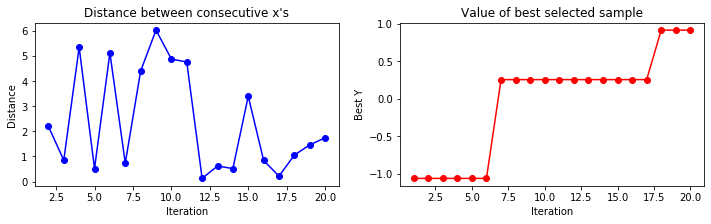

In [112]:
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Number of iterations
n_iter = 20
trials = 10
y_maxes = np.zeros((trials, n_iter))

for trial in range(trials):
    y_max_watermark = None
    X_sample = X_init
    Y_sample = Y_init
    y = Y_sample[len(X_init):].ravel()
    y_max_watermark = np.maximum.accumulate(y)

    for i in range(n_iter):
        X_next = random_location(bounds)
        Y_next = f(X_next, noise)

        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

        y = Y_sample[len(X_init):].ravel()
        y_max_watermark = np.maximum.accumulate(y)
    print(len(y_max_watermark))
    y_maxes[trial, :] = y_max_watermark

    
plot_convergence(X_sample, Y_sample)


In [98]:
X_sample

array([[-2.10000000e+00],
       [ 3.10000000e+00],
       [ 3.08148119e+00],
       [ 1.79152952e-03],
       [ 1.71721165e+00],
       [ 1.51413982e+00],
       [ 9.61067232e-02],
       [-1.00850335e+00],
       [ 2.62257003e+00],
       [-8.52428516e-01],
       [-5.89100221e-01],
       [-2.46430883e+00],
       [-1.30078339e+00],
       [-2.21611861e+00],
       [ 1.22527784e+00],
       [-2.63729444e+00],
       [ 1.63714301e+00],
       [-1.57740323e+00],
       [ 3.01439017e+00],
       [ 3.80707225e+00],
       [ 1.62234297e+00],
       [-1.96293503e+00],
       [ 3.71258723e+00],
       [-1.82782269e+00],
       [ 2.30189976e+00],
       [ 4.58166806e+00],
       [-2.15839772e-01],
       [ 2.37831478e+00],
       [-2.75434596e+00],
       [-1.93864429e+00],
       [-1.44617832e+00],
       [ 3.99672836e+00],
       [-1.07450601e+00],
       [ 3.48699040e+00],
       [-2.44251973e+00],
       [ 1.82042982e+00],
       [ 4.02345984e+00],
       [ 2.13195193e+00],
       [ 1.8

In [66]:
print([random_location(bounds) for i in range(10)])

[array([[3.04760178]]), array([[2.55453988]]), array([[2.87631445]]), array([[2.03992589]]), array([[2.03515556]]), array([[3.56820466]]), array([[3.18842782]]), array([[2.86177029]]), array([[2.4532714]]), array([[2.60085721]])]
